# Convolutional Neural Network: Live Gesture Recognition

## Data Processing

Begins with checking if my GPU is properly connected to tensorflow, as this will greatly impact the development time of the model.

In [12]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import time
from tensorflow.keras import datasets, layers, models, optimizers



print(device_lib.list_local_devices() )
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Current device: {}".format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3492217527396779620
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1704956817278019658
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4922553139
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11055604905613251323
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12631419018343158412
physical_device_desc: "device: XLA_GPU device"
]
Num GPUs Available:  1
Current device: /device:GPU:0


### Importing Our Image Dataset
This data import assumes that this program and the NUS dataset folder **dataset** lie in the same directory.

1.     The folder 'Hand Postures' contains the 10 class hand posture images (160x120 size). Classes 1 to 10 are named with starting letters 'a' to 'j' respectively.  A total of 2000 hand posture images are present in this folder.

2.     The folder 'Hand Postures with human noise' contains the 10 class hand posture images (320x240 size) with human noises (face of the posturer, human in the background etc). Classes 1 to 10 are named with starting letters 'a_HN' to 'j_HN' respectively.  A total of 750 hand posture images are present in this folder.

3.     The folder 'Backgrounds' contains the background images. A total of 2000 background images are available.

4.     All the images are RGB and in .jpeg format.

In [13]:
import cv2
import numpy as np
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
plt.style.use('ggplot')

def get_images():
    """
    
    Uses cv2, os and numpy to loop through the folder 
    directories and import all images and their labels into numpy arrays X and Y.
    
    Output
    -----
    X: images
        type numpy.array
    Y: labels
        type numpy.array
        
    """
    
    base = 'dataset'
    if os.path.lexists(os.path.join(os.getcwd(), base)):
        directory = os.listdir(base)

    X = []
    Y =[]
    for item in directory:
        path =  base + '/' + item
        files = os.listdir(path)
        for image in files:
            final_path = path + '/' + image
            try:
                img =cv2.imread(final_path)
                img = cv2.resize(img, (160, 120))
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
                X.append(img)
                if item == "Hand Postures with human noise":
                    label = image.split("_")[0]
                else:
                    label = image.split()[0]
                label = label.split('.')[0]
                Y.append(label)
            except:
                continue
   
    X = np.array(X, dtype="uint8")
    X = X.reshape(len(X), 120, 160, 3) # Needed to reshape so CNN knows it's different images
    Y = np.array(Y)
    print("Images loaded: ", len(X))
    print("Labels loaded: ", len(Y))
    
    return X,Y


Convert our labels from categorical to numerical values.

In [14]:
def process_Y(Y):
    class_names = list(np.unique(Y))
    for item in class_names:
        print(item, ": ", len(np.where(Y == item)[0]))
    for i,item in enumerate(Y):
        if item in class_names:
            Y[i] = int(class_names.index(item)) 
    Y =  np.array(Y, dtype="uint8")
    return class_names, Y

**Note**: Processing this try/except process ensures that the dataset is loaded the quickest way. If you have already run this notebook before, this will save you time.

In [15]:
try:
    class_names =np.load("class_names.npy")
    x_train =np.load("x_train.npy")
    y_train = np.load("y_train.npy")
    x_test = np.load("x_test.npy")
    y_test = np.load("y_test.npy")
    
    print("Successfully loaded in the data WITH train-test split")
    
except:
    print("Failed to load pickled dataset WITH train-test split")
    
    try:
        X = np.load('images.npy')
        Y = np.load('labels.npy')
        class_names = np.load("class_names.npy")
        print("Loaded X (inputs) and Y (labels)")
        
    except:
        print("Failed to load pickled dataset WITHOUT train-test split")
        X,Y = get_images()
        class_names, Y = process_Y(Y)
        for i,item in enumerate(X):
            X[i] = item[:,:,::-1]
        X = X[1725:]   #balance the dataset by removing some background images
        Y = Y[1725:]   #balance the dataset by removing some background images
        np.save("images.npy",X)
        np.save("labels.npy",Y)
        np.save("class_names.npy", class_names)
        print("Computed New X and Y values")


Successfully loaded in the data WITH train-test split


In [16]:
true_class_names = ['nothing', 'fist', 'palm', "two fingers up", "shakabra", "o k", "egyptian hand", "U", "L",
                   "talking hand", "two fingers sideways"]
list(class_names), list(np.unique(Y))

NameError: name 'Y' is not defined

In [18]:
def split_the_data(X, Y):   
    
    X = X/255.0  ## normalize X array
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    np.save("x_train.npy",x_train)
    np.save("y_train.npy",y_train)
    np.save("x_test.npy",x_test)
    np.save("y_test.npy",y_test)
    return x_train, x_test, y_train, y_test

In [19]:
try:
    
    x_train, x_test, y_train, y_test = split_the_data(X, Y)      ## Split the data into a training and testing set
   # print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape)
    del X,Y               # delete X and Y from memory
    
except:
    print("Failed to split the data")

Failed to split the data


Text(0.5, 1.0, 'egyptian hand')

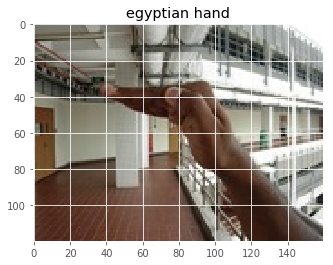

In [20]:
plt.imshow(x_train[200])
plt.title(str(true_class_names[y_train[200]]))

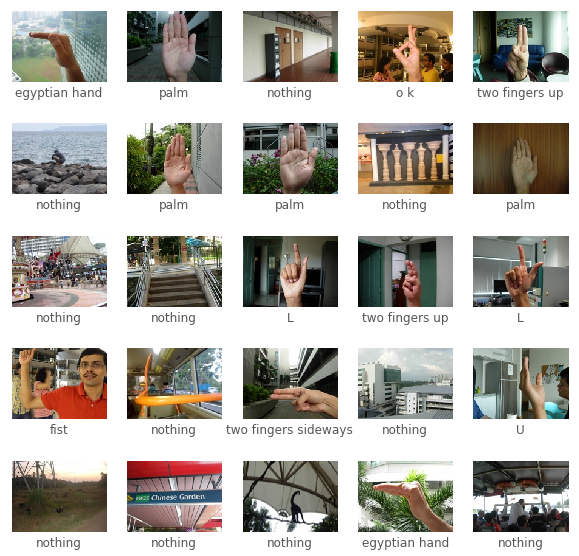

In [21]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(true_class_names[y_train[i]])
plt.show()

In [24]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(120, 160, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3)))
    
    

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(11))
    
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'] )
    return model

In [25]:
def fit(model, epochs):
    history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs=epochs, verbose = 1)
    return history

In [26]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [27]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 116, 156, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 58, 78, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 76, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 56, 76, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 7, 64)          0

In [28]:
history = fit(model, 100)

Epoch 1/100
119/119 [==============================] - 5s 43ms/step - loss: 2.0369 - accuracy: 0.4224 - val_loss: 2.0003 - val_accuracy: 0.4158
Epoch 2/100
119/119 [==============================] - 4s 37ms/step - loss: 1.8649 - accuracy: 0.4224 - val_loss: 1.7582 - val_accuracy: 0.4158
Epoch 3/100
119/119 [==============================] - 4s 37ms/step - loss: 1.6474 - accuracy: 0.4258 - val_loss: 1.5342 - val_accuracy: 0.4316
Epoch 4/100
119/119 [==============================] - 4s 37ms/step - loss: 1.4382 - accuracy: 0.4889 - val_loss: 1.4416 - val_accuracy: 0.4811
Epoch 5/100
119/119 [==============================] - 4s 37ms/step - loss: 1.3076 - accuracy: 0.5282 - val_loss: 1.2402 - val_accuracy: 0.5568
Epoch 6/100
119/119 [==============================] - 4s 37ms/step - loss: 1.1501 - accuracy: 0.5776 - val_loss: 1.2447 - val_accuracy: 0.5663
Epoch 7/100
119/119 [==============================] - 4s 37ms/step - loss: 1.0722 - accuracy: 0.5984 - val_loss: 1.0711 - val_accuracy:

119/119 [==============================] - 4s 37ms/step - loss: 0.0573 - accuracy: 0.9816 - val_loss: 0.6411 - val_accuracy: 0.8611
Epoch 58/100
119/119 [==============================] - 4s 37ms/step - loss: 0.0574 - accuracy: 0.9811 - val_loss: 0.5223 - val_accuracy: 0.8779
Epoch 59/100
119/119 [==============================] - 4s 37ms/step - loss: 0.0230 - accuracy: 0.9939 - val_loss: 0.5585 - val_accuracy: 0.8863
Epoch 60/100
119/119 [==============================] - 4s 37ms/step - loss: 0.0443 - accuracy: 0.9892 - val_loss: 0.5270 - val_accuracy: 0.8958
Epoch 61/100
119/119 [==============================] - 4s 37ms/step - loss: 0.0146 - accuracy: 0.9939 - val_loss: 0.6283 - val_accuracy: 0.8832
Epoch 62/100
119/119 [==============================] - 4s 37ms/step - loss: 0.0216 - accuracy: 0.9932 - val_loss: 0.5616 - val_accuracy: 0.8737
Epoch 63/100
119/119 [==============================] - 4s 37ms/step - loss: 0.0982 - accuracy: 0.9721 - val_loss: 0.8764 - val_accuracy: 0.806

30/30 - 1s - loss: 0.5528 - accuracy: 0.8874


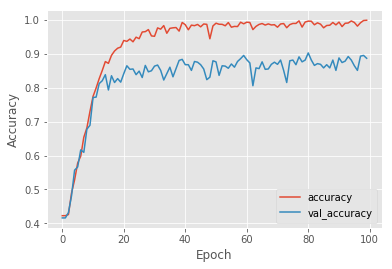

In [31]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig("Accuracy.png")
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

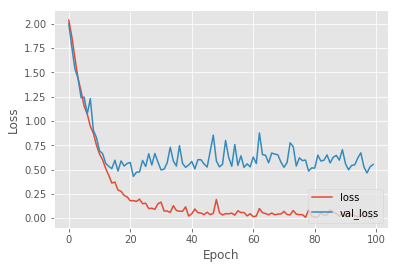

In [32]:
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.savefig("Loss.png")

In [33]:
model.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model\assets


## Model Validation

Now that we've trained and saved our best model, let's look at a **Confusion Matrix** for our model's predictions

In [34]:
model = tf.keras.models.load_model('saved_model/my_model')

In [35]:
predictions = model.predict(x_test)

In [36]:
y_pred = np.argmax(predictions, axis = 1)

conf_columns = []
for item in true_class_names:
    conf_columns.append("Predicted " + item)

conf_indicies = []
for item in true_class_names:
    conf_indicies.append("Actual " + item)
    
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                       columns = conf_columns,
                       index = conf_indicies)

In [38]:
conf_mat

,Predicted nothing,Predicted fist,Predicted palm,Predicted two fingers up,Predicted shakabra,Predicted o k,Predicted egyptian hand,Predicted U,Predicted L,Predicted talking hand,Predicted two fingers sideways
Actual nothing,383,4,0,0,1,1,2,1,1,2,0
Actual fist,2,45,0,0,1,0,0,0,3,0,1
Actual palm,3,3,44,2,0,1,0,1,1,0,0
Actual two fingers up,2,1,6,50,0,2,0,1,2,0,0
Actual shakabra,1,4,1,0,49,1,0,2,0,1,0
Actual o k,3,2,0,1,0,46,2,0,1,0,0
Actual egyptian hand,1,1,0,0,1,0,50,0,0,1,4
Actual U,2,0,0,0,3,3,0,52,1,0,0
Actual L,4,5,0,1,0,2,0,0,37,0,0
Actual talking hand,4,1,0,0,0,0,4,0,0,43,3


In [39]:
def guess(model, index, x_test = x_test):
    output = model.predict(x_test[index].reshape((1,120,160,3)))
    plot_prediction(index = index, output = output)

In [40]:
def plot_prediction(index, output, true_class_names = true_class_names, class_names = class_names):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize = (15,10))
 
    plt.figure(figsize=(12,30))
    clrs = ['blue' if (x == class_names[y_test[index]]) else 'grey' for x in class_names]
    ax1.bar(true_class_names, output[0], color = clrs)
    ax1.set_ylim([0, max(output[0])])
    ax1.set_title("Predicted value: {}".format(true_class_names[np.argmax(output[0])]))
    ax2.imshow(x_test[index])
    ax2.set_title("True value: {}".format(true_class_names[y_test[index]]))
    #plt.ylim(0, output[0].max())
    plt.show()

In [41]:
len(x_test)

950

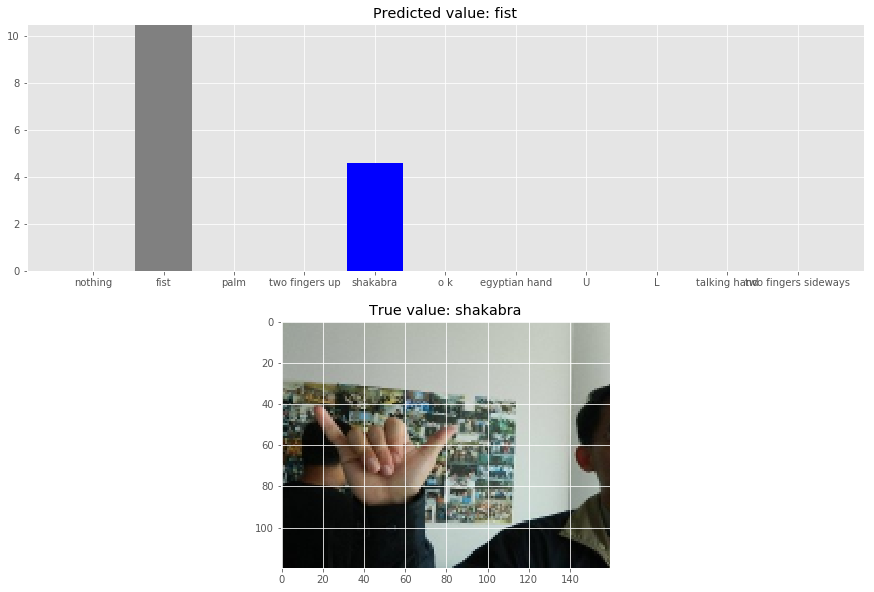

<Figure size 864x2160 with 0 Axes>

Gesture:  two fingers sideways
--- 0.43982410430908203 seconds ---


In [42]:
start_time = time.time()
guess(model,22)
print("Gesture: ", true_class_names[np.argmax(model.predict(x_test[0].reshape((1,120,160,3))))])
print("--- %s seconds ---" % (time.time() - start_time))

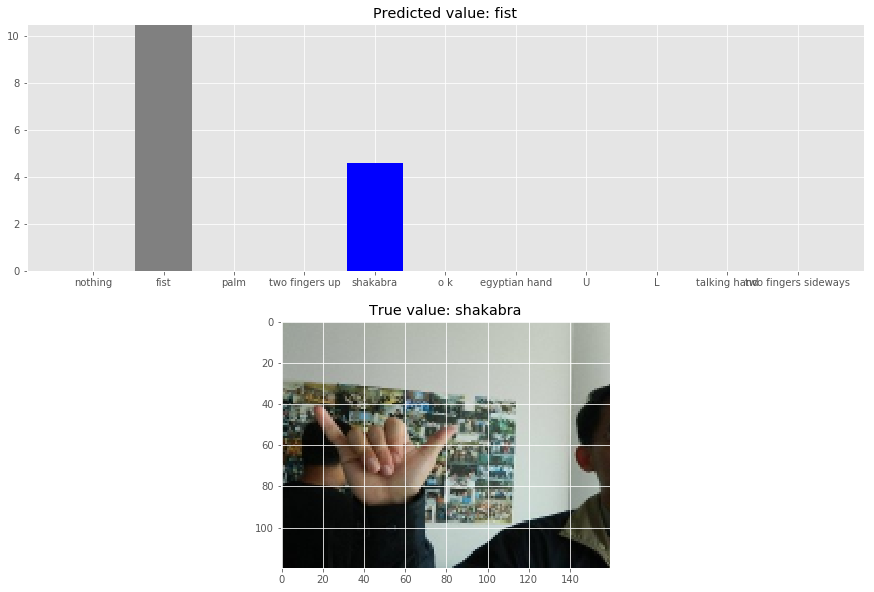

<Figure size 864x2160 with 0 Axes>

In [43]:
guess(model, 22)

Run Time:  0.03191494941711426 seconds

Take the average vector output over multiple frames in order to get highest probability gesture!!!

if 60fps... 3 frames /60 frames = 50 / 1000 miliseconds = 0.05 seconds
1 frame / 60 frames = 16.66/1000 miliseconds = 0.0166 seconds

Use multiple cap.read() calls to get images at each time step to average across

ValueError: 'nothing' is not a valid estimator for `bins`

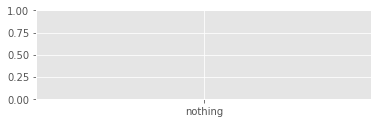

In [45]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

cap = cv2.VideoCapture(0) 

last_prediction = ""
run = True




while run:
    # update data
    
    
    #_, img = cap.read()
    
    ret, frame = cap.read()

  #  res = cv2.imread(user_input)

  #
    img = cv2.resize(frame,  (160, 120), interpolation=cv2.INTER_CUBIC)
    
    model_output = model.predict(img.reshape((1,120,160,3)))
    
    prediction = true_class_names[np.argmax(model_output)]
    
    if ((time.time() - start_time) >= 0.5) and prediction != last_prediction:
        start_time = time.time()
        
        fig = plt.figure()
        fig.subplots_adjust(top=0.8)
        ax1 = fig.add_subplot(211)
        ax1.hist(true_class_names, prediction)

        
        
        print("Gesture: ", prediction)
        print("--- %s seconds --- between each barplot." % (time.time() - start_time))
        last_prediction  = prediction
    
    cv2.imshow("image", image)
    cv2.imshow("Live Feed", frame)
    #cv2.imshow()
    key = cv2.waitKey(1)
    if key == 27:   ##Using the escape key
        break
cap.release()
cv2.destroyAllWindows()

C:\Users\Stephen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


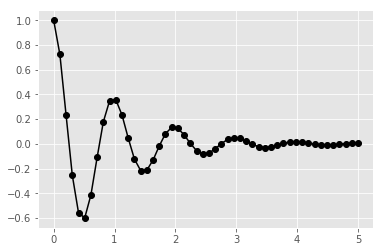

In [51]:
fig = plt.figure()
cap = cv2.VideoCapture(0)


x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)


bar, = plt.bar(true_class_names,  model.predict(x_test[0].reshape((1,120,160,3)))[0])        # so that we can update data later
run = True
while run:
    # update data
    
    bar.set_ydata( model.predict(img.reshape((1,120,160,3)))) )

    # redraw the canvas
    fig.canvas.draw()

    # convert canvas to image
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8,
            sep='')
    img  = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # img is rgb, convert to opencv's default bgr
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)


    # display image with opencv or any operation you like
    cv2.imshow("plot",img)

    # display camera feed
    ret,frame = cap.read()
    cv2.imshow("cam",frame)

    k = cv2.waitKey(1)
    if k == 27:
        run = False

In [7]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import numpy as np
import cv2

fig = Figure()
canvas = FigureCanvas(fig)
ax = fig.gca()

ax.hist(x=np.array([1,2,3]), height = np.array([5,6,20]))
#ax.axis('off')

canvas.draw()       # draw the canvas, cache the renderer

image = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
cv2.imshow("im",image)

ValueError: setting an array element with a sequence.

(array([24., 16., 17., 10., 24., 27., 16., 23., 15., 20., 27., 16., 14.,
        28., 25., 19., 19., 18., 22., 20., 24., 23., 18., 28., 13., 16.,
        19., 27., 17., 13., 16., 15., 13., 30., 21., 20., 14., 27., 26.,
        25., 16., 12., 27., 26., 18., 22., 20., 15., 18., 21.]),
 array([0.00114697, 0.02110966, 0.04107235, 0.06103505, 0.08099774,
        0.10096043, 0.12092312, 0.14088581, 0.1608485 , 0.18081119,
        0.20077388, 0.22073657, 0.24069926, 0.26066195, 0.28062465,
        0.30058734, 0.32055003, 0.34051272, 0.36047541, 0.3804381 ,
        0.40040079, 0.42036348, 0.44032617, 0.46028886, 0.48025156,
        0.50021425, 0.52017694, 0.54013963, 0.56010232, 0.58006501,
        0.6000277 , 0.61999039, 0.63995308, 0.65991577, 0.67987846,
        0.69984116, 0.71980385, 0.73976654, 0.75972923, 0.77969192,
        0.79965461, 0.8196173 , 0.83957999, 0.85954268, 0.87950537,
        0.89946807, 0.91943076, 0.93939345, 0.95935614, 0.97931883,
        0.99928152]),
 <a list of 50

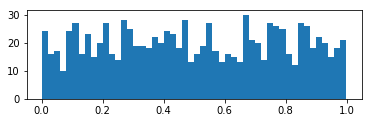

In [8]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(211)
ax1.hist(np.random.rand(1000), 50)

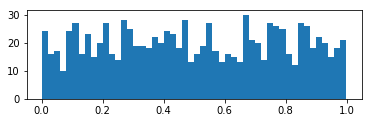

In [9]:
fig